In [1]:
import json
import os
from scene_objects import Scene_Objects
from collections import defaultdict
from grounding import *
import functools

data_dir = "/home/mary/Code/spatial-reasoning/custom_clevr/output/scenes/"
scene_file = "CLEVR_train_000000.json"
output_dir = "/home/mary/Code/spatial-reasoning/relations/"
example_expressions = "/home/mary/Code/spatial-reasoning/relations/expressions/example_expressions.json"

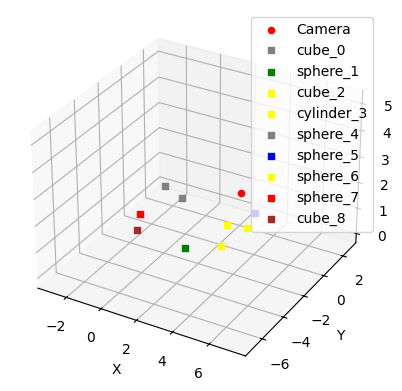

In [2]:
with open(os.path.join(data_dir, scene_file)) as data:
    scene_data = json.load(data)

scene_info = Scene_Objects(scene_data)
entities = scene_info.all_entities

with open(example_expressions) as examples:
    proc_expressions = json.load(examples)


Qualifying objects: [(3, -0.25853444260298425), (2, -0.42701635071804844), (6, -0.5186155111879361), (5, -0.6941577124563846)]
Best object: (3, -0.25853444260298425)


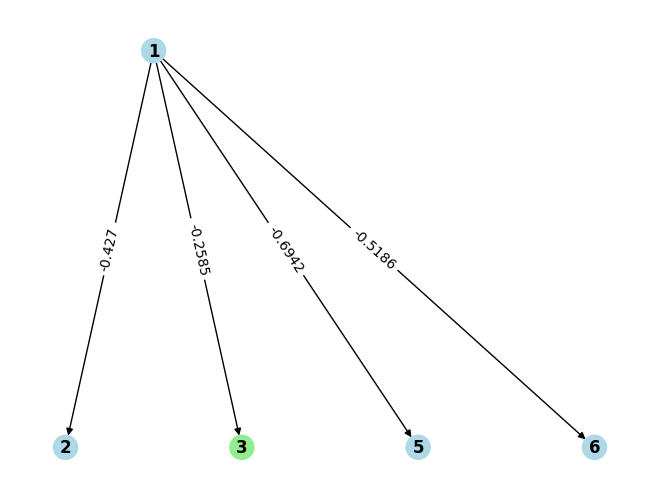

In [5]:

scene_predictor = SpatialPredictor(scene_info)
scene_predictor.relate(proc_expressions[2]['mentions'])
scene_predictor.show_candidate_graph()


In [4]:
# between
# relative distance
# next to
# leaf node with the highest incoming edge scores?